In [8]:
from Kernel import *

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
help(rough_compute)

Help on function rough_compute in module Kernel:

rough_compute(A_inv_initial, start, steps, delta_t, gamma, laboratory_frame=False, resolution=5, D=1.0)
    Returns inverse of covariance matrix after "steps - start" particles have been added, given starting A^{-1}
    
    steps is the number of particles to add (start = 0 with 2 particles including base means steps = 0)
    
    delta_t is essentially inverse velocity
    
    Size of matrices is expanded by 'resolution' every time they are filled. Continues until
    target number of steps has been reached. Higher resolution means lower accuracy but faster computation time.



In [11]:
help(fixed_frame_compute)

Help on function fixed_frame_compute in module Kernel:

fixed_frame_compute(A_inv_initial, steps, delta_t, gamma, cur_size, precision=1, laboratory_frame=False, D=1.0)
    Returns precise covariance matrices in the current frame given starting A. 
    
    steps is the number of particles the have been inserted (steps = 0 means 2 particles including base)
    
    Output is time lattice and corresponding covariance matrices.
    
    delta_t is the time before the new addition.
    
    precision is the number of subdivisions of delta_t (if precision == 1, optimal value is calculated)



In [12]:
def r_g(A, N):
    res = 0.
    for i in range(N):
        for j in range(N):
            res += A[i,i] - 2 * A[i,j] + A[j, j]
    return res/(2 * N * N)

In [13]:
import matplotlib.pyplot as plt

%matplotlib notebook

#number of particles to add
rough_steps = 50

#coupling constant
gamma = 10.0

#inverse velocity
dt = 0.01

#matrix element, max(m,n) should be < resolution
m, n = 1, 1

CovsL = [x for x in range (rough_steps)]
CovsLab = [x for x in range(rough_steps)]

Matrix_Element = np.zeros((rough_steps))
Radii = np.zeros((rough_steps))
#Initialisation. Returns the usual parabolic variance after dt at [0,0] and +np.inf at [k,k]
Ainv = initialize_A_inv(dt, D, resolution = 5)

CovsL[0] = Ainv
    
for j in range(1, rough_steps):
    
    cov = rough_compute(CovsL[j-1], j-1, 1, dt, gamma, False, resolution = 5)
    CovsL[j] = cov
   
    
for j in range(0, rough_steps):
    CovsLab[j] = ToLab(CovsL[j], j, np.shape(CovsL[j])[0])
    CovsLab[j] = np.linalg.inv(CovsLab[j])
    Radii[j] = r_g(CovsLab[j], j + 1)
    
for j in range(0,rough_steps):
    Matrix_Element[j] = CovsLab[j][m][n]

<IPython.core.display.Javascript object>


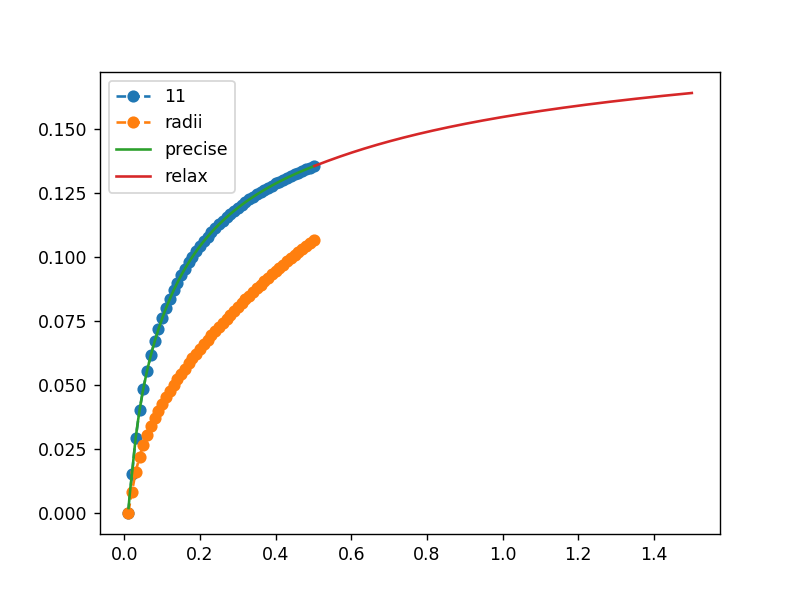

In [14]:
latfin = np.empty((0))
Datfin = np.empty((0))
for k in range(rough_steps):
    
    lat, Covv = fixed_frame_compute(CovsL[k], k, dt, gamma, np.shape(CovsL[k])[0], precision = 10)
    
    CovvL = np.asarray([np.linalg.inv(ToLab(cc, k, np.shape(cc)[0])) for cc in Covv])
    
    latfin = np.append(latfin, lat + (k + 1) *dt)
    Datfin = np.append(Datfin, CovvL[:,m,n])
    
fig1 = plt.figure()

t = np.linspace(dt, dt * (rough_steps), num = (rough_steps))
plt.plot(t, Matrix_Element,'--o', label='%d%d' %(m, n))
plt.plot(t, Radii,'--o', label='radii')

plt.plot(latfin, Datfin, '-', label = 'precise')
plt.legend()

Быстрее выходит на плато, если раньше остановить рост. Как бы выстреливает по касательной

In [15]:
drop_time = 50
relax_time = rough_steps * 2

lat1, Covv1 = fixed_frame_compute(CovsL[drop_time -1], drop_time - 1, dt * relax_time, gamma, np.shape(CovsL[drop_time - 1])[0], precision = 500)
    
CovvL1 = np.asarray([np.linalg.inv(ToLab(cc, drop_time - 1, np.shape(cc)[0])) for cc in Covv1])
latfin1 = np.empty((0))
Datfin1 = np.empty((0))    
latfin1 = np.append(latfin1, lat1 + (drop_time) *dt)
Datfin1 = np.append(Datfin1, CovvL1[:,m,n])
plt.plot(latfin1, Datfin1, '-', label = 'relax')
plt.legend()


This seems to work, but recheck steps and steps +1 in both rough_compute and fixed_frame_compute (and everywhere else as well)